# Project - Market Day

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>

![Stardew Valley](https://venturebeat.com/wp-content/uploads/2018/01/sw7rtba7p1xs77klsime.png)

It is Market Day! You've been working hard for a whole season, planting, watering, and taking care of crops. Now it is time to sell them in town. Just one problem though - your old truck can only carry so much weight. Which crops should you bring to maximize your profits? 

In this project, you will use a stochastic algorithm of your choice to find the best crop configuration you can load into your truck. You know how much stock you have of each crop, how much each crop weighs, and what price it will fetch at the market. You should use these values throughout the project.

Before we start, if you're using colab to run this notebook, you'll need to uncomment and run the following lines:

In [1]:
#!wget https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/market.csv
#!wget https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/recipes.csv
#!pip install pymoo

In [2]:
import numpy as np
import pandas as pd
import pymoo
import copy
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('market.csv', index_col=0)
df["price_average"] = (df["price_A"]+df["price_B"]+df["price_C"])/3
df.head()

,stock,weight,price_A,price_B,price_C,price_average
Apple,5,5,1.00,0.5,1.1,0.866667
Apricot,65,3,0.50,0.2,0.6,0.433333
Blueberry,5,3,0.50,0.3,1.2,0.666667
Cactus Fruit,90,4,0.75,0.3,0.3,0.450000
Cherry,15,4,0.80,0.4,1.1,0.766667


$\textbf{Price average is added for later comparison.}$

In [4]:
stock = df['stock'].to_dict()
weight = df['weight'].to_dict()
price = df['price_A'].to_dict()

In [5]:
stock

{'Apple': 5,
 'Apricot': 65,
 'Blueberry': 5,
 'Cactus Fruit': 90,
 'Cherry': 15,
 'Cranberry': 75,
 'Grape': 70,
 'Melon': 75,
 'Orange': 40,
 'Peach': 55,
 'Pomegranate': 5,
 'Rhubarb': 70,
 'Starfruit': 5,
 'Strawberry': 20,
 'Amaranth': 20,
 'Artichoke': 65,
 'Beet': 30,
 'Bok Choy': 55,
 'Cauliflower': 70,
 'Corn': 90,
 'Eggplant': 95,
 'Garlic': 95,
 'Green Bean': 55,
 'Hops': 75,
 'Hot Pepper': 25,
 'Kale': 5,
 'Parsnip': 10,
 'Potato': 55,
 'Pumpkin': 30,
 'Radish': 50,
 'Red Cabbage': 55,
 'Tomato': 65,
 'Wheat': 75,
 'Yam': 50,
 'Blackberry': 70}

To evaluate your possible load going to the market, we will use a function that takes in a dictionary of this type, specifying how many of each crop you will take. This function will take into the constraints of having enough stock of the crop type and of not surpassing the weight limit.

In [6]:
def evaluate(load, stock, weight, price, max_weight=5000):
    total_weight = 0
    total_price = 0
    for k in load:
        if load[k] <= stock[k]:
            total_price += load[k] * price[k]
            total_weight += load[k] * weight[k]
            if total_weight > max_weight:
                return 0
        else:
            return 0
    return total_price

You can try this with an example load generated randomly:

In [7]:
trial_load = {}
for k in stock:
    trial_load[k] = np.random.randint(0, stock[k])
trial_load

{'Apple': 2,
 'Apricot': 56,
 'Blueberry': 0,
 'Cactus Fruit': 48,
 'Cherry': 4,
 'Cranberry': 30,
 'Grape': 26,
 'Melon': 9,
 'Orange': 25,
 'Peach': 35,
 'Pomegranate': 0,
 'Rhubarb': 53,
 'Starfruit': 0,
 'Strawberry': 13,
 'Amaranth': 13,
 'Artichoke': 3,
 'Beet': 10,
 'Bok Choy': 5,
 'Cauliflower': 53,
 'Corn': 33,
 'Eggplant': 79,
 'Garlic': 84,
 'Green Bean': 13,
 'Hops': 14,
 'Hot Pepper': 1,
 'Kale': 0,
 'Parsnip': 9,
 'Potato': 36,
 'Pumpkin': 25,
 'Radish': 2,
 'Red Cabbage': 30,
 'Tomato': 18,
 'Wheat': 47,
 'Yam': 13,
 'Blackberry': 15}

In [8]:
evaluate(trial_load, stock, weight, price)

675.8499999999998

## Challenge 1

Use a stochastic algorithm to find the configuration of crops that maximizes profit while respecting the constraints of the weight limit and stock. You can use any of the class code or a library like `pymoo`. You should create a reasonable representation for the problem and appropriate modification functions like mutation and crossover. You can also modify the evaluation function, as long as your final solution is valid according to the weight and stock constraints.

Include your code for optimization, any visualizations of the optimization process, as well as code to show the final market load and profit gained. Can you beat the random trial load profits?

Hint: this is a constrained case of the [knapsack problem](https://en.wikipedia.org/wiki/Knapsack_problem)

In [9]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.optimize import minimize
from pymoo.operators.mutation.rm import ChoiceRandomMutation

# prob: influe nombre de mutation/crossover 1=50% mutation
# eta: "variance" de l'écart aux valeurs de mutations/crossover, petit=forte variance
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=100,
    sampling=IntegerRandomSampling(),
    crossover=SBX(prob=1.0, eta=1.0, repair=RoundingRepair()),
    mutation=PM(prob=1.0, eta=1.0, repair=RoundingRepair()),
    eliminate_duplicates=True
)

In [10]:
from pymoo.core.problem import ElementwiseProblem
from typing import List

# Multi-Objective KnapSack Problem 
class MOKSP(ElementwiseProblem):
    
    def __init__(self, df: pd.DataFrame, list_obj: List[int], max_weight: int=5000, verbose: bool=True):      
        # Check on input : list_obj
        for obj in list_obj:
            assert 1 <= obj <= 4, "Values in list_obj are not in [1, 2, 3, 4]"
        
        self.n_var = df.shape[0]
        self.max_weight = max_weight
        self.df = df
        
        if verbose:
            print("Row count : ", df.shape[0])
            print(self.df)
        
        # lower bound
        xl = np.zeros(self.n_var)
        # upper bound
        xu = self.df['stock'].values
        
        self.price_keys = [x for x in df.columns.to_list() if "price" in x]
        
        
        self.stock = self.df['stock'].values
        self.weight = self.df['weight'].values
        self.price = []
        
        for obj in list_obj:
            self.price.append(self.df[self.price_keys[obj-1]].values)
        
        super().__init__(n_var=self.n_var, n_obj=len(list_obj), n_constr=1, xl=xl, xu=xu)
    
    def compute_price_and_weight(self, load):
        total_weight = 0
        total_price = np.zeros(len(self.price))
        for i in range(len(self.price)):
            for k in range(load.shape[0]):
                total_price[i] += load[k] * self.price[i][k]
                if i==0:
                    total_weight += load[k] * self.weight[k]
        return total_weight, total_price
    
    def _evaluate(self, x, out, *args, **kwargs):

        total_weight, fits = self.compute_price_and_weight(x)
        
        fits = -fits # The optimizer only works with minimization
        
        c = total_weight - self.max_weight
        
        # return by modifying out
        out["F"] = fits
        out["G"] = c

In [11]:
problem = MOKSP(df, [1], 5000, verbose=False)
res = minimize(problem,
               algorithm,
               ("n_gen", 100),
               seed=1,
               save_history=True,
               verbose=False)
print("Done")

Done


In [93]:
def get_convergence(results, max_weight = 5000):
    n_gen = np.array([e.evaluator.n_eval for e in results.history])/results.history[0].evaluator.n_eval
    score = -np.array([e.opt[0].F for e in results.history])
    load = np.array([e.opt[0].X for e in results.history])
    load_weight =  max_weight + np.array([e.opt[0].G for e in results.history])
    
    time = results.exec_time
    
    if len(score[0]) > 1: # Multi-Optimization
        n_obj = score.shape[1]+1
        score = np.zeros((score.shape[0], n_obj))
        load = np.zeros((load.shape[0], load.shape[1], n_obj))
        load_weight = np.zeros((score.shape[0], n_obj))
        
        for i in range(len(results.history)):
            e = results.history[i]
            for k in range(len(e.opt)):
                new = -e.opt[k].F
                for m in range(n_obj):
                    if m == n_obj-1:
                        if np.mean(new) > score[i,n_obj-1]:
                            score[i,n_obj-1] = np.mean(new)
                            load[i, :, m] = e.opt[k].X
                            load_weight[i, m] = max_weight + e.opt[k].G
                    else:
                        if new[m] > score[i,m]:
                            score[i,m] = new[m]
                            load[i, :, m] = e.opt[k].X
                            load_weight[i, m] = max_weight + e.opt[k].G
                            
    return n_gen, score, load, time, load_weight

        
        
def plot_convergence(n_gen, score, fmt: str="-", label: str=" "):
    
    plt.plot(n_gen, score, fmt,  label=label)
    
    plt.title("Convergence")
    plt.xlabel("Generation")
    plt.ylabel("Total load price")
    plt.legend()
    plt.tight_layout

def print_convergence(n_gen, score, load, time, weight):
    
    print("Training time : ", np.round(time,3), "s", "\t(", np.round(time/n_gen[-1],5), "s/gen)")
    
    if score.shape[1] == 1:
        print("Best score : \t", score[-1])
        print("Weight : \t", weight[-1])
        print("Load breakdown : \n", load[-1])

    else:
        print("\nMultiple solutions exist : \n")

        print("\nBest mean score : ", score[-1, -1], " Score detail : ", score[-1])
        print("Weight : \t", weight[-1, -1])
        print("Load breakdown : \n", load[-1, :,-1])
        
        for i in range(score.shape[1]-1):
            print("\nBest single score : ", score[-1, i])
            print("Weight : \t", weight[-1, i])
            print("Load breakdown : \n", load[-1, :, i])

    print("\n\n")

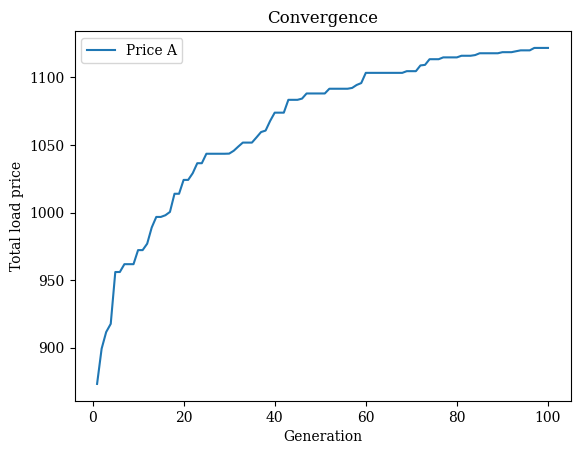

In [98]:
n_gen, score, load, time, load_weight = get_convergence(res)
plot_convergence(n_gen, score, label="Price A")

In [99]:
print_convergence(n_gen, score, load, time, load_weight)

Training time :  6.001 s 	( 0.06001 s/gen)
Best score : 	 [1121.8]
Weight : 	 [4999.]
Load breakdown : 
 [ 2 62  0 87 14 73 65  0 33 51  4  0  0 15 19 64 28 52 68 85 93 94 41  0
 18  0  6 55  0 47 40 61  4 49 57]





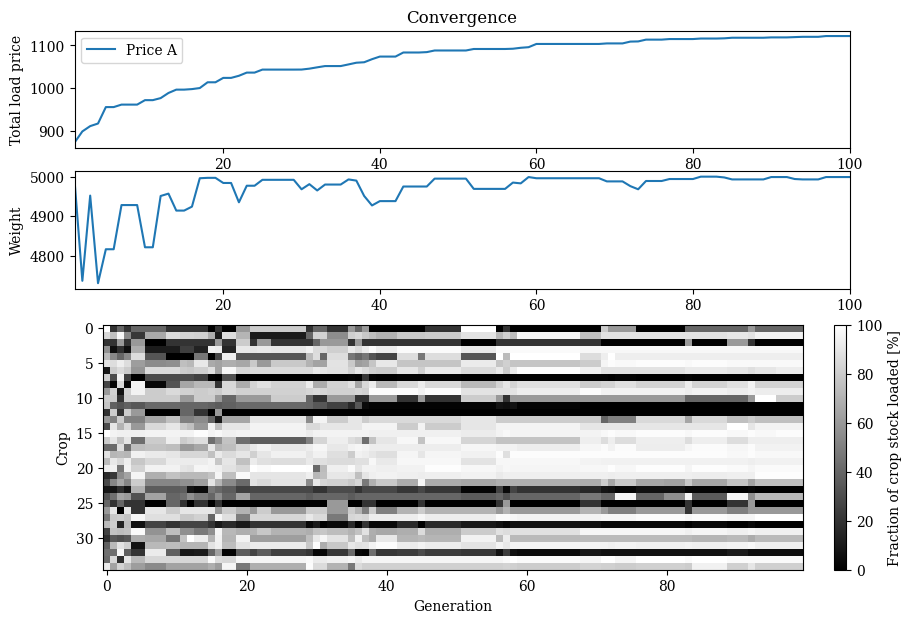

In [173]:
img = 1.0*np.copy(np.transpose(load))
norm = 1.0*np.copy(df.stock.values)
for i in range(img.shape[1]):
        img[:, i] = img[:, i]/norm*100

plt.figure(figsize=(10,7))
plt.subplot(4,1,1)
plot_convergence(n_gen, score, label="Price A")
plt.xlim([np.min(n_gen), np.max(n_gen)])

plt.subplot(4,1,2)
plt.plot(n_gen, load_weight)
plt.xlim([np.min(n_gen), np.max(n_gen)])
plt.ylabel("Weight")

plt.subplot(2,1,2)
im = plt.imshow(img, cmap='gray')
plt.xlabel("Generation")
plt.ylabel("Crop")
cbar = plt.colorbar(im, fraction=0.02, pad=0.04)
cbar.set_label("Fraction of crop stock loaded [%]")
plt.tight_layout
print()

## Challenge 2


The agricultural market in this world is highly variable. This time, you'll be selling your load to a reseller, but you're not sure which one. Each reseller has different prices, so it depends on which one you'll meet. To be prepared, you should explore the possible options.

In [72]:
price_a = df['price_A'].to_dict()
price_b = df['price_B'].to_dict()
price_c = df['price_C'].to_dict()

In [73]:
price_a['Cherry'], price_b['Cherry'], price_c['Cherry']

(0.8, 0.4, 1.1)

Given that cherries have very different prices between the different resellers, the example load we made ealier would fetch a wildly different price depending on the reseller:

In [74]:
a = evaluate(trial_load, stock, weight, price_a)
b = evaluate(trial_load, stock, weight, price_b)
c = evaluate(trial_load, stock, weight, price_c)
print(a, b, c)

675.8499999999998 321.30000000000007 394.9000000000001


Prepare four different options for your market day haul: one option that will be good for reseller A, one for reseller B, one for reseller C, and one which would be pretty good for all three. Display these options and compare their different prices.

Hint: you can use a multi-objective algorithm to optimize for all three reseller prices at the same time.

In [75]:
# Running same optimizer but with different objectives
problem_list = []
res_list = []

# List of objectives to optimize on
obj_list_list = [[1], [2], [3], [4], [1, 2, 3]] # 1=Price A, 2=Price B, 3=Price C, 4=Price Average

for obj_list in obj_list_list:
    print("Optimizing on objective(s) :", obj_list)
    
    problem_list.append(MOKSP(df, obj_list, 5000, verbose=False))
    res_list.append(
        minimize(problem_list[-1],
        algorithm,
        ("n_gen", 100),
        seed=1,
        save_history=True,
        verbose=False)
    )

Optimizing on objective(s) : [1]
Optimizing on objective(s) : [2]
Optimizing on objective(s) : [3]
Optimizing on objective(s) : [4]
Optimizing on objective(s) : [1, 2, 3]


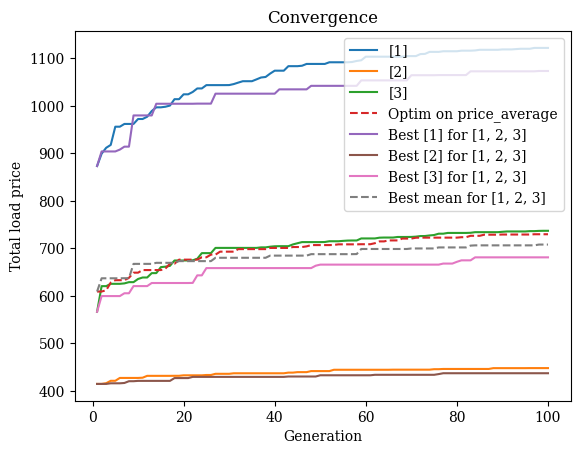

In [76]:
score_single = []

for i in range(len(obj_list_list)):
    n_gen, score, load, _, _ = get_convergence(res_list[i])
    
    if i < len(obj_list_list)-1:
        score_single += list(score[-1,:])
    else:
        score_multi = score[-1,:]
    
    if len(obj_list_list[i]) > 1:
        for j in range(score.shape[1]):
            if j == score.shape[1]-1:
                plot_convergence(n_gen, score[:,j], "--" , label="Best mean for " + str(obj_list_list[i]))
            else:
                plot_convergence(n_gen, score[:,j], label="Best " + str([obj_list_list[i][j]]) + " for " + str(obj_list_list[i]))
    else:
        if obj_list_list[i][0] == 4:
            plot_convergence(n_gen, score,"--", label="Optim on price_average")
        else:
            plot_convergence(n_gen, score, label=str(obj_list_list[i]))

score_single = np.array(score_single)
score_multi = np.array(score_multi)

In [77]:
print("Score for multiple single optimizations (4th=avg):\t", score_single)
print("Score for single multi optimization (4th=avg):\t\t", score_multi)
print("Improovement by doing multiple single optimizations [%]:", (score_single-score_multi)/score_single*100)

Score for multiple single optimizations (4th=avg):	 [1121.8         447.9         736.9         729.63333333]
Score for single multi optimization (4th=avg):		 [1073.25        437.1         681.          707.91666667]
Improovement by doing multiple single optimizations [%]: [4.32786593 2.41125251 7.58583254 2.97638083]


One can clearly see that optimizing on one objective is better that taking the best solution out of a multi-objective optimization. Knowing this, an optimization on the averaged price $Price_{average} = \frac{Price_A + Price_B + Price_C}{3}$ yields a better result than our current "Best mean for [1, 2, 3]".

Not only single objective optimization yields better performances, it is also faster to execute.

In [78]:
t_tot = 0
for i in [0,1,2,3]:
    t_tot += res_list[i].exec_time
print("Total time for 4 single optimizations :\t", t_tot, "s")
print("Total time for 1 multi optimization :\t", res_list[4].exec_time, "s")
print("\nMulti parameter optimization is", np.round(t_tot/res_list[4].exec_time , 2), "times faster.")

Total time for 4 single optimizations :	 24.11329174041748 s
Total time for 1 multi optimization :	 9.012660503387451 s

Multi parameter optimization is 2.68 times faster.


But the multi-objective is more flexible. If one does not know in advance the specific weights for each objectives, training a multi-parameter optimization allow the user to choose at a later date the best result according to the objective weights.

Here this difference is not a problem since the computation is fast, but for a heavier problem requiering hours or days of training, the multi-optimization solution is preferable.

In [95]:
# Now we will fetch the resulting loads :
for i in range(len(obj_list_list)):
    print("Optimization for : ", obj_list_list[i])
    n_gen, score, load, time, load_weight = get_convergence(res_list[i])
    print_convergence(n_gen, score, load, time, load_weight)

Optimization for :  [1]
Training time :  6.068 s 	( 0.06068 s/gen)
Best score : 	 [1121.8]
Weight : 	 [4999.]
Load breakdown : 
 [ 2 62  0 87 14 73 65  0 33 51  4  0  0 15 19 64 28 52 68 85 93 94 41  0
 18  0  6 55  0 47 40 61  4 49 57]



Optimization for :  [2]
Training time :  6.038 s 	( 0.06038 s/gen)
Best score : 	 [447.9]
Weight : 	 [4996.]
Load breakdown : 
 [ 2  1  1 20 11 39  4 59 39 54  0 62  0 18 16 28 22  4 62 13  8  7 12 28
 16  1  6  3 25 43 48  1 35 41  4]



Optimization for :  [3]
Training time :  5.999 s 	( 0.05999 s/gen)
Best score : 	 [736.9]
Weight : 	 [4997.]
Load breakdown : 
 [ 4 63  4 56 15 59 66 34 38 26  0  0  0 19 17 63 27 54 23 86 91 62 54 72
 24  4  9 54  0 48  1 64 68 46 68]



Optimization for :  [4]
Training time :  6.008 s 	( 0.06008 s/gen)
Best score : 	 [729.63333333]
Weight : 	 [4992.]
Load breakdown : 
 [ 4 56  1 62 10 59 66 32 39 51  1  0  0 18 19 62 27 54 65 87 93 69 50 11
 24  2  8 54  0 49 10 60  5 48 64]



Optimization for :  [1, 2, 3]
Traini

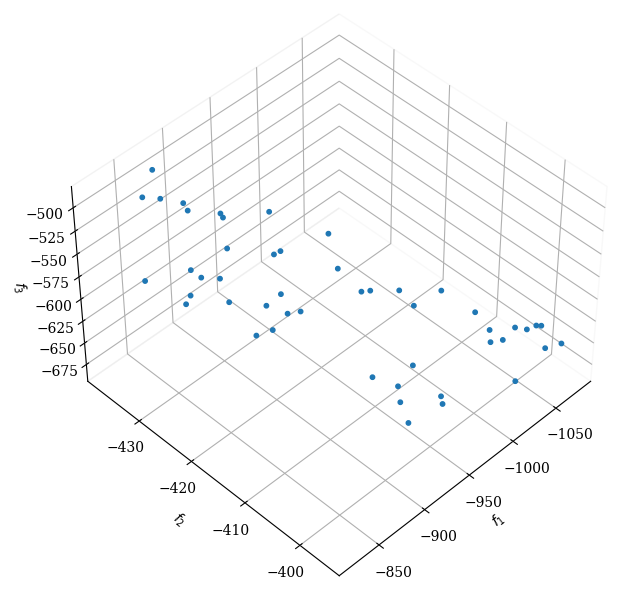

In [80]:
from pymoo.visualization.scatter import Scatter
plot = Scatter(tight_layout=True)
plot.add(res_list[-1].F, s=10)
plot.show()

## Challenge 3

You decide to preprare some of your crops by making food for the market day. You know a number of recipes and are famous for your delicious fruit pies.

In [ ]:
recipes = {'Ratatouille': {'Eggplant': 2, 'Garlic': 2, 'Tomato': 4, 'Hot Pepper': 1},
 'Apple Pie': {'Apple': 10, 'Wheat': 5},
 'Apricot Pie': {'Apricot': 10, 'Wheat': 5},
 'Cherry Pie': {'Cherry': 10, 'Wheat': 5},
 'Rhubarb Pie': {'Rhubarb': 10, 'Wheat': 5},
 'Strawberry Pie': {'Strawberry': 10, 'Wheat': 5},
 'Blackberry Pie': {'Blackberry': 10, 'Wheat': 5},
 'Pumpkin Pie': {'Pumpkin': 10, 'Wheat': 5},
 'Pizza': {'Tomato': 3, 'Wheat': 2, 'Artichoke': 1},
 'Baba Ghanoush': {'Eggplant': 2, 'Garlic': 4},
 'Squash Soup': {'Yam': 3, 'Pumpkin': 1},
 'Peach Beer': {'Hops': 3, 'Peach': 1},
 'Blackberry Beer': {'Hops': 3, 'Blackberry': 1}}

These recipes sell for good prices at each of the resellers:

In [ ]:
dfr = pd.read_csv('recipes.csv', index_col=0)
dfr["price_average"] = (dfr["price_A"]+dfr["price_B"]+dfr["price_C"])/3
dfr.head()

In [ ]:
# Get weight of each recipe and the max craftable amount

dfr["weight"] = 0
dfr["stock"] = df["stock"].max()

for n, recipe in enumerate(recipes):
    ingredients = recipes[recipe]
    w = 0
    for i in ingredients:
        w += weight[i] * ingredients[i]
        if dfr.loc[recipe]["stock"] > df.loc[i]["stock"]/ingredients[i]:
            dfr.loc[recipe, "stock"] = int(np.floor(df.loc[i]["stock"]/ingredients[i]))
    dfr.loc[recipe, "weight"] = w

In [ ]:
df_tot = pd.concat((df, dfr), copy=True, ignore_index=False)
df_tot

$\textbf{Not enough apples for a single apple pie :'(}$

In [ ]:
price_a.update(dfr['price_A'].to_dict())
price_b.update(dfr['price_B'].to_dict())
price_c.update(dfr['price_C'].to_dict())
price_a['Apple Pie'], price_b['Apple Pie'], price_c['Apple Pie']

Modify the evaluation function to take into account these recipes, making sure not to break the weight or stock constraints. The weight of a recipe is the sum total weight of the ingredients, and you can not make a recipe if you don't have the remaining stock of ingredients. Here's an example of calculating the total weight of a random load of only recipes:

In [ ]:
recipe_load = {}
for k in recipes:
    recipe_load[k] = np.random.randint(0, 5)
recipe_load

In [ ]:
def get_weight(recipe_load, recipes, weight):
    total_weight = 0
    for k in recipe_load:
        ingredients = recipes[k]
        w = 0
        for i in ingredients:
            w += weight[i] * ingredients[i]
        total_weight += w * recipe_load[k]
    return total_weight

In [ ]:
get_weight(recipe_load, recipes, weight)

Once you've modified the evaluation function, rerun the optimization algorithm to find a new load for the three resellers, and one load which is good for all three. Display this result and the profit gained, making sure that the constraints are met.

In [ ]:
# Get the matrix to compute how many raw ressources are necessary for the given load
# This will be used to check ressource availability = new constraint

M = np.zeros((dfr.shape[0], df.shape[0]))

raw_names = list(df.index)
recipes_names = list(recipes.keys())


for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        recipe = recipes_names[i]
        raw = raw_names[j]
        if  raw in list(recipes[recipe].keys()):
            M[i,j] = recipes[recipe][raw]

raw_ressources = np.matmul(np.array(list(recipe_load.values())),M)

print("Ressources required to craft all the recipes according to : 'recipe_load'")
for i in range(raw_ressources.shape[0]):
    print(f'{raw_names[i]:<15}', f'{raw_ressources[i]:<4}')

In [ ]:
class MOKSP_bis(ElementwiseProblem):
    
    def __init__(self, df: pd.DataFrame, list_obj: List[int], max_weight: int=5000, verbose: bool=True):      
        # Check on input : list_obj
        for obj in list_obj:
            assert 1 <= obj <= 4, "Values in list_obj are not in [1, 2, 3, 4]"
        
        self.n_var = df.shape[0]
        self.max_weight = max_weight
        self.df = df
        
        if verbose:
            print("Row count : ", df.shape[0])
            print(self.df)
        
        # lower bound
        xl = np.zeros(self.n_var)
        # upper bound
        xu = self.df['stock'].values
        
        self.price_keys = [x for x in df.columns.to_list() if "price" in x]
        
        
        self.stock = self.df['stock'].values
        self.weight = self.df['weight'].values
        self.price = []
        
        for obj in list_obj:
            self.price.append(self.df[self.price_keys[obj-1]].values)
        
        # n_constr = 1 + 35 : 1 for weight, 35 for ressources
        super().__init__(n_var=self.n_var, n_obj=len(list_obj), n_constr=36, xl=xl, xu=xu)
    
    def compute_price_and_weight(self, load):
        total_weight = 0
        total_price = np.zeros(len(self.price))
        for i in range(len(self.price)):
            for k in range(load.shape[0]):
                total_price[i] += load[k] * self.price[i][k]
                if i==0: # Only compute weight once (here after the computation of first price/objective)
                    total_weight += load[k] * self.weight[k]
        return total_weight, total_price
    
    def compute_required_ressources(self, load):
        craft = load[35:]
        ressources = np.matmul(craft, M)
        return load[:35]+ressources
        
    def _evaluate(self, x, out, *args, **kwargs):

        total_weight, fits = self.compute_price_and_weight(x)
        
        fits = -fits # The optimizer only works with minimization
        
        c = np.zeros(self.n_constr)
        c[0] = total_weight - self.max_weight
        c[1:] = self.compute_required_ressources(x) - self.stock[:35]
        
        # return by modifying out
        out["F"] = fits
        out["G"] = c

In [ ]:
# Running same optimizer but with different objectives
problem_list = []
res_list = []

# List of objectives to optimize on
obj_list_list = [[1], [2], [3], [4], [1, 2, 3]] # 1=Price A, 2=Price B, 3=Price C, 4=Price Average

for obj_list in obj_list_list:
    print("Optimizing on objective(s) :", obj_list)
    
    problem_list.append(MOKSP_bis(df_tot, obj_list, 5000, verbose=False))
    res_list.append(
        minimize(problem_list[-1],
        algorithm,
        ("n_gen", 100),
        seed=1,
        save_history=True,
        verbose=False)
    )

In [ ]:
score_single = []

for i in range(len(obj_list_list)):
    n_gen, score = get_convergence(res_list[i])
    
    if i < len(obj_list_list)-1:
        score_single += list(score[-1,:])
    else:
        score_multi = score[-1,:]
    
    if len(obj_list_list[i]) > 1:
        for j in range(score.shape[1]):
            if j == score.shape[1]-1:
                plot_convergence(n_gen, score[:,j], "--" , label="Best mean for " + str(obj_list_list[i]))
            else:
                plot_convergence(n_gen, score[:,j], label="Best " + str([obj_list_list[i][j]]) + " for " + str(obj_list_list[i]))
    else:
        if obj_list_list[i][0] == 4:
            plot_convergence(n_gen, score,"--", label="Optim on price_average")
        else:
            plot_convergence(n_gen, score, label=str(obj_list_list[i]))

score_single = np.array(score_single)
score_multi = np.array(score_multi)

In [ ]:
print("Score for multiple single optimizations (4th=avg):\t", score_single)
print("Score for single multi optimization (4th=avg):\t\t", score_multi)
print("Improovement by doing multiple single optimizations [%]:", (score_single-score_multi)/score_single*100)

In [ ]:
t_tot = 0
for i in [0,1,2,3]:
    t_tot += res_list[i].exec_time
print("Total time for 4 single optimizations :\t", t_tot, "s")
print("Total time for 1 multi optimization :\t", res_list[4].exec_time, "s")
print("\nMulti parameter optimization is", np.round(t_tot/res_list[4].exec_time , 2), "times faster.")

One can see that single optimization is not necessary the best result here. The very high dimension for the constraint is maybe linked to it. Let's try summing all the ressources constraints to one master constraint.

In [ ]:
class MOKSP_ter(ElementwiseProblem):
    
    def __init__(self, df: pd.DataFrame, list_obj: List[int], max_weight: int=5000, verbose: bool=True):      
        # Check on input : list_obj
        for obj in list_obj:
            assert 1 <= obj <= 4, "Values in list_obj are not in [1, 2, 3, 4]"
        
        self.n_var = df.shape[0]
        self.max_weight = max_weight
        self.df = df
        
        if verbose:
            print("Row count : ", df.shape[0])
            print(self.df)
        
        # lower bound
        xl = np.zeros(self.n_var)
        # upper bound
        xu = self.df['stock'].values
        
        self.price_keys = [x for x in df.columns.to_list() if "price" in x]
        
        
        self.stock = self.df['stock'].values
        self.weight = self.df['weight'].values
        self.price = []
        
        for obj in list_obj:
            self.price.append(self.df[self.price_keys[obj-1]].values)
        
        # n_constr = 1 + 1 : 1 for weight, 1 for master constraint on ressources
        super().__init__(n_var=self.n_var, n_obj=len(list_obj), n_constr=2, xl=xl, xu=xu)
    
    def compute_price_and_weight(self, load):
        total_weight = 0
        total_price = np.zeros(len(self.price))
        for i in range(len(self.price)):
            for k in range(load.shape[0]):
                total_price[i] += load[k] * self.price[i][k]
                if i==0: # Only compute weight once (here after the computation of first price/objective)
                    total_weight += load[k] * self.weight[k]
        return total_weight, total_price
    
    def compute_required_ressources(self, load):
        craft = load[35:]
        ressources = np.matmul(craft, M)
        return load[:35]+ressources
        
    def _evaluate(self, x, out, *args, **kwargs):

        total_weight, fits = self.compute_price_and_weight(x)
        
        fits = -fits # The optimizer only works with minimization
        
        c = np.zeros(self.n_constr)
        c[0] = total_weight - self.max_weight
        cons = self.compute_required_ressources(x) - self.stock[:35]
        c[1] = np.sum(cons[cons>0])
        
        # return by modifying out
        out["F"] = fits
        out["G"] = c

In [ ]:
# Running same optimizer but with different objectives
problem_list = []
res_list = []

# List of objectives to optimize on
obj_list_list = [[1], [2], [3], [4], [1, 2, 3]] # 1=Price A, 2=Price B, 3=Price C, 4=Price Average

for obj_list in obj_list_list:
    print("Optimizing on objective(s) :", obj_list)
    
    problem_list.append(MOKSP_ter(df_tot, obj_list, 5000, verbose=False))
    res_list.append(
        minimize(problem_list[-1],
        algorithm,
        ("n_gen", 1000),
        seed=1,
        save_history=True,
        verbose=False)
    )

In [ ]:
score_single = []

for i in range(len(obj_list_list)):
    n_gen, score, _, _, _ = get_convergence(res_list[i])
    
    if i < len(obj_list_list)-1:
        score_single += list(score[-1,:])
    else:
        score_multi = score[-1,:]
    
    if len(obj_list_list[i]) > 1:
        for j in range(score.shape[1]):
            if j == score.shape[1]-1:
                plot_convergence(n_gen, score[:,j], "--" , label="Best mean for " + str(obj_list_list[i]))
            else:
                plot_convergence(n_gen, score[:,j], label="Best " + str([obj_list_list[i][j]]) + " for " + str(obj_list_list[i]))
    else:
        if obj_list_list[i][0] == 4:
            plot_convergence(n_gen, score,"--", label="Optim on price_average")
        else:
            plot_convergence(n_gen, score, label=str(obj_list_list[i]))

score_single = np.array(score_single)
score_multi = np.array(score_multi)

In [ ]:
print("Score for multiple single optimizations (4th=avg):\t", score_single)
print("Score for single multi optimization (4th=avg):\t\t", score_multi)
print("Improovement by doing multiple single optimizations [%]:", (score_single-score_multi)/score_single*100)

In [ ]:
t_tot = 0
for i in [0,1,2,3]:
    t_tot += res_list[i].exec_time
print("Total time for 4 single optimizations :\t", t_tot, "s")
print("Total time for 1 multi optimization :\t", res_list[4].exec_time, "s")
print("\nMulti parameter optimization is", np.round(t_tot/res_list[4].exec_time , 2), "times faster.")

## Evaluation

You should submit a saved copy of your notebook (including all of the cell output) to the LMS by December 13th, EOD. You may work with one partner, but you must **individually submit a notebook**. You will be graded based on your results, your code, and any text or visual explanations, according to the following rubric:

Criterion | Points | Marks
--- | --- | ---
Results - Challenge 1 | 7 | 7
Results - Challenge 2 | 5 | 5
Results - Challenge 3 | 3 | 3
Presentation (code, text) | 5 | 5
Total | 20 | 20
| | :p 